# Pearson heat maps

Creates pearson heat maps for host gal properties and pew or velocity.

Creates a dataframe of pearson values which are significant.

## imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from pandas import DataFrame

## creating entries for heatmap

In [2]:
def heat_map_entry(table):
    """Create arrays to enter into the plot_heat_map function
    Args:
        table     (DataFrame): The data to use
    Returns:
        carray_pew    (array): array of c values against pew
        parray_pew    (array): array of p values against pew
        carray_vel    (array): array of c values against vel
        parray_vel    (array): array of p values against vel
    """
 
    # keeps only features 1-7
    table = table.iloc[:7,:]
    # creates indexed table
    itable = table.set_index('features')
    # keeps properties we want to plot
    itable = itable.iloc[:,8:]

    # creates dfs of just c and p values and just pew and vel
    ctable = itable[itable.columns[::2]]
    ptable = itable[itable.columns[1::2]]
    ctable_pew = ctable[ctable.columns[::2]]
    ctable_vel = ctable[ctable.columns[1::2]]
    ptable_pew = ptable[ptable.columns[::2]]
    ptable_vel = ptable[ptable.columns[1::2]]
    
    #makes dfs into arrays
    carray_pew = ctable_pew.to_numpy()
    carray_vel = ctable_vel.to_numpy()
    parray_pew = ptable_pew.to_numpy()
    parray_vel = ptable_vel.to_numpy()

    return carray_pew, parray_pew, carray_vel, parray_vel

In [3]:
features = [f'pW{i}' for i in range(1, 8)]
properties = ['logMassFSPS', 'logSSFRFSPS',
              'ageFSPS','kpc',]

# heatmap plotting functions

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
def plot_heat_map(carray, parray, against):
    """plots 2 heat maps for c and p value respectively
       host gal properties on vertical axis and features on horizontal
    Args:
        carray     (array): array of c values
        parray     (array): array of p values
        against    (string): pew or vel
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    # 1st plot


    im, _ = heatmap(carray, features, properties, ax=ax1,
                cmap="coolwarm", cbarlabel=f"pearson correlation values for property vs. {against}")
    annotate_heatmap(im, valfmt="{x:.3f}", size=10, color=('black'))

    # 2nd plot

    im, _ = heatmap(parray, features, properties, ax=ax2, vmin=0,
                cmap="Blues", cbarlabel=f"p values for property vs. {against}")
    annotate_heatmap(im, valfmt="{x:.3f}", size=10, threshold=0.6,
                 textcolors=("black","white"))

    plt.tight_layout()
    plt.show()

# heat maps for all SNe

In [6]:
table = pd.read_csv("/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/pearson_table.csv")
#table = pd.read_csv("/Users/ellakane/Desktop/research/SN-Spectral-Evolution/results/pearson_table.csv")
carray_pew, parray_pew, carray_vel, parray_vel = heat_map_entry(table)

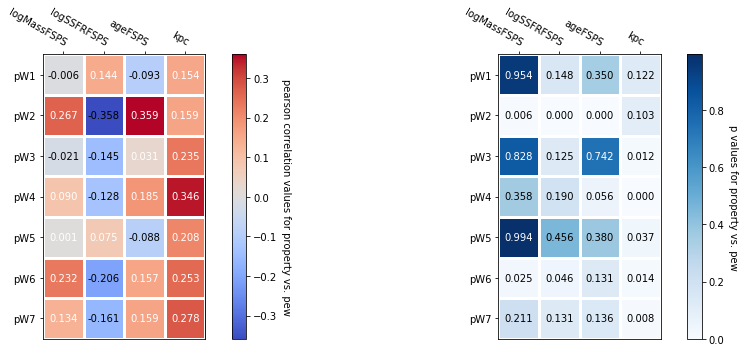

In [7]:
plot_heat_map(carray_pew, parray_pew, 'pew')

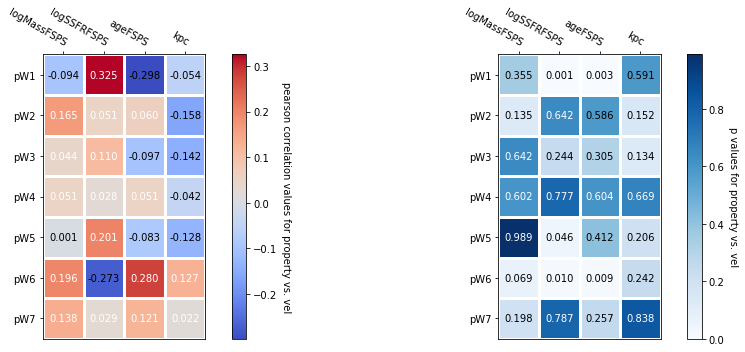

In [8]:
plot_heat_map(carray_vel, parray_vel, 'vel')

# for broad line

In [9]:
bl_table = pd.read_csv("/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/bl_pearson_table.csv")
bl_carray_pew, bl_parray_pew, bl_carray_vel, bl_parray_vel = heat_map_entry(bl_table)

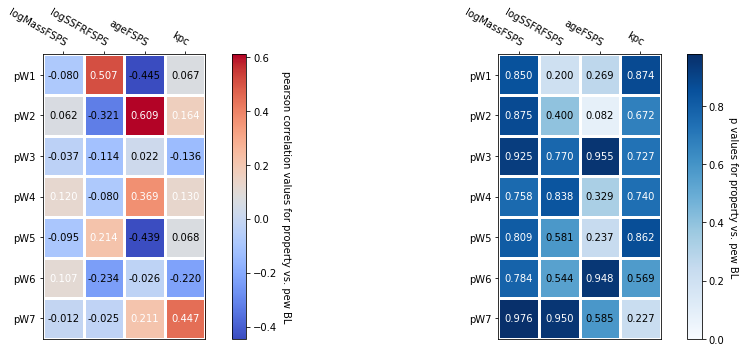

In [10]:
plot_heat_map(bl_carray_pew, bl_parray_pew, 'pew BL')

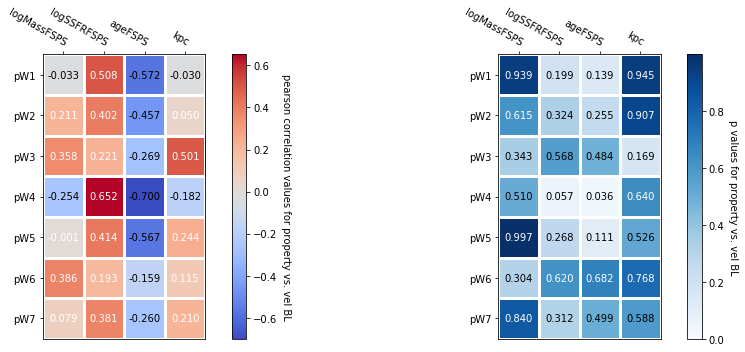

In [11]:
plot_heat_map(bl_carray_vel, bl_parray_vel, 'vel BL')

# for shallow silicon

In [12]:
ss_table = pd.read_csv("/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/ss_pearson_table.csv")
ss_carray_pew, ss_parray_pew, ss_carray_vel, ss_parray_vel = heat_map_entry(ss_table)

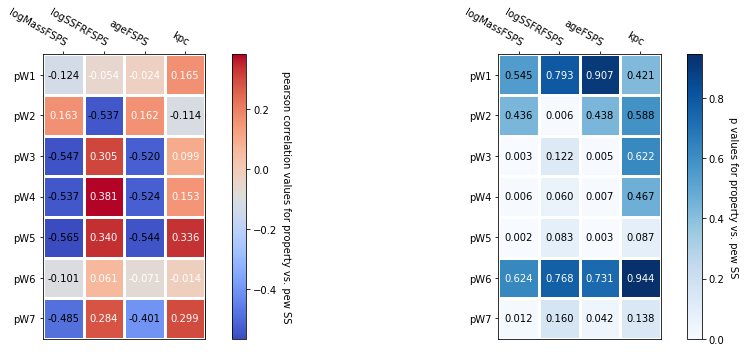

In [13]:
plot_heat_map(ss_carray_pew, ss_parray_pew, 'pew SS')

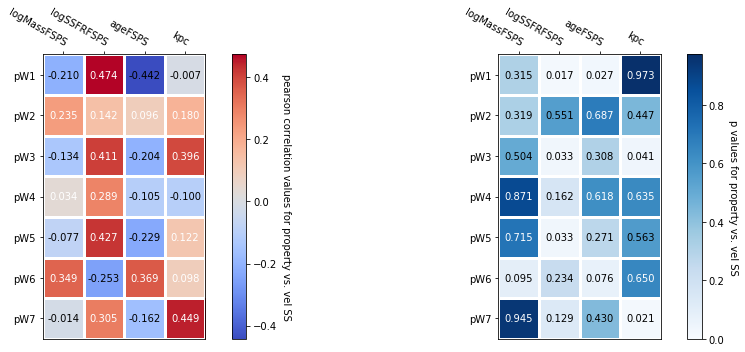

In [14]:
plot_heat_map(ss_carray_vel, ss_parray_vel, 'vel SS')

# for cool

In [15]:
cl_table = pd.read_csv("/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/cl_pearson_table.csv")
cl_carray_pew, cl_parray_pew, cl_carray_vel, cl_parray_vel = heat_map_entry(cl_table)

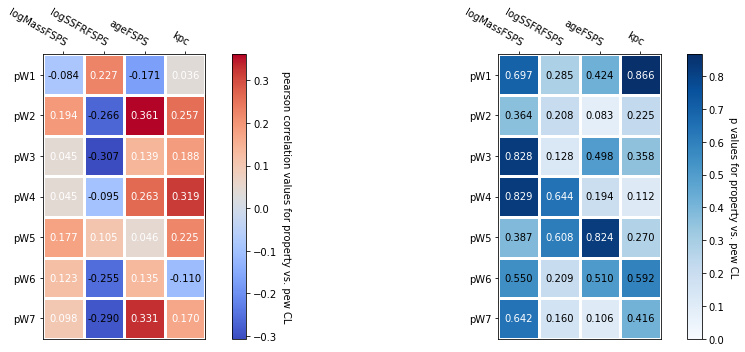

In [16]:
plot_heat_map(cl_carray_pew, cl_parray_pew, 'pew CL')

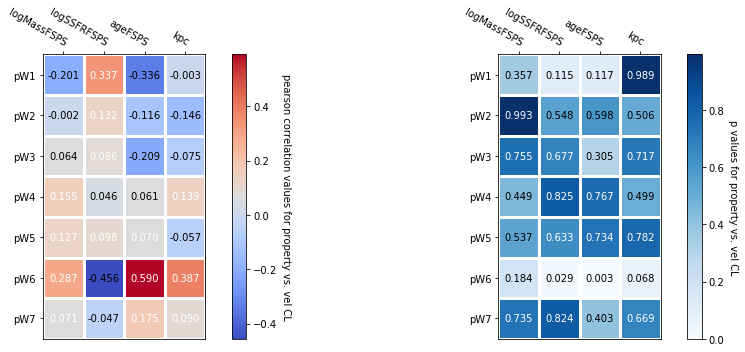

In [17]:
plot_heat_map(cl_carray_vel, cl_parray_vel, 'vel CL')

# for core normal

In [18]:
cn_table = pd.read_csv("/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/cn_pearson_table.csv")
cn_carray_pew, cn_parray_pew, cn_carray_vel, cn_parray_vel = heat_map_entry(cn_table)

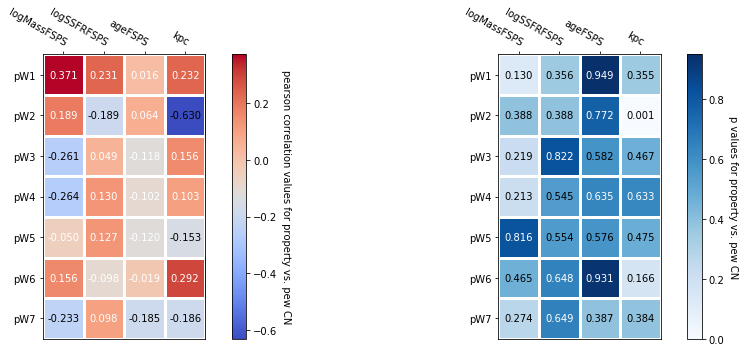

In [19]:
plot_heat_map(cn_carray_pew, cn_parray_pew, 'pew CN')

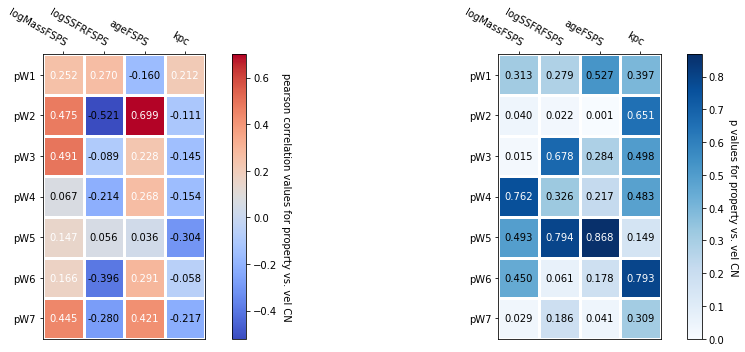

In [20]:
plot_heat_map(cn_carray_vel, cn_parray_vel, 'vel CN')

In [23]:
def significant_list(table):
    """Create significant pearson values dataframe by both c and p cutoffs
    Args:
        table     (DataFrame): The data to use
    Returns:
        df        (DataFrame): dataframe of significant pearson values  
    """
 
    # keeps only features 1-7
    table = table.iloc[:7,:]
    # creates indexed table
    itable = table.set_index('features')
    #im not sure if we need to set index or not!!
    #itable = table
    # keeps properties we want to plot
    itable = itable.iloc[:,8:]
    # creates dfs of just c and p values and just pew and vel
    ctable = itable[itable.columns[::2]].reset_index()
    ictable = itable[itable.columns[::2]]
    cprops = ctable.columns.values.tolist()
    ptable = itable[itable.columns[1::2]].reset_index()
    iptable = itable[itable.columns[1::2]]
    pprops = ptable.columns.values.tolist()
    
    name_list = []
    feat_list = []
    c_list = []
    p_list = []
    
    #breakpoint()
    for i, j in zip(cprops[1:], pprops[1:]):
        ccolumn = ictable[i]
        pcolumn = iptable[j]
        cname = i
        pname = j
   
        for c, p in zip(ccolumn, pcolumn):
            cindex = ictable[ictable[cname]==c].index.values
            if ((np.abs(c) >= 0.4) and (p <= 0.05)):
                name_list.append(cname)
                feat_list.append(cindex)
                c_list.append(c)
                p_list.append(p)
                #print(cname, cindex, c, p)
            else:
                continue
    data = {'property_comparison':name_list, 'feature':feat_list, 'c':c_list, 'p':p_list}
    df = pd.DataFrame(data, columns=['property_comparison','feature','c','p'])
    return df

In [24]:
def significant_p_list(table):
    """Create significant pearson values dataframe by just p cutoffs
    Args:
        table     (DataFrame): The data to use
    Returns:
        df        (DataFrame): dataframe of significant pearson values
    """
 
    # keeps only features 1-7
    table = table.iloc[:7,:]
    # creates indexed table
    itable = table.set_index('features')
    #im not sure if we need to set index or not!!
    #itable = table
    # keeps properties we want to plot
    itable = itable.iloc[:,8:]
    # creates dfs of just c and p values and just pew and vel
    ctable = itable[itable.columns[::2]].reset_index()
    ictable = itable[itable.columns[::2]]
    cprops = ctable.columns.values.tolist()
    ptable = itable[itable.columns[1::2]].reset_index()
    iptable = itable[itable.columns[1::2]]
    pprops = ptable.columns.values.tolist()
    
    name_list = []
    feat_list = []
    c_list = []
    p_list = []
    
    #breakpoint()
    for i, j in zip(cprops[1:], pprops[1:]):
        ccolumn = ictable[i]
        pcolumn = iptable[j]
        cname = i
        pname = j
   
        for c, p in zip(ccolumn, pcolumn):
            cindex = ictable[ictable[cname]==c].index.values
            if np.abs(p) <= 0.05:
                name_list.append(cname)
                feat_list.append(cindex)
                c_list.append(c)
                p_list.append(p)
                #print(cname, cindex, c, p)
            else:
                continue
    data = {'property_comparison':name_list, 'feature':feat_list, 'c':c_list, 'p':p_list}
    df = pd.DataFrame(data, columns=['property_comparison','feature','c','p'])
    return df

### All data

In [37]:
#df of significant trends for all data
sig_all = significant_list(table)
all_list = ['ALL']*len(sig_all['c'])
sig_all['data_used'] = all_list

In [38]:
#df of only p significant trends for all data
sig_p_all = significant_p_list(table)
all_p_list = ['ALL']*len(sig_p_all['c'])
sig_p_all['data_used'] = all_p_list

In [39]:
#df of significant trends for cl data only
sig_cl = significant_list(cl_table)
cl_list = ['CL only']*len(sig_cl['c'])
sig_cl['data_used'] = cl_list

In [40]:
#df of only p significant trends for cl data only
sig_p_cl = significant_p_list(cl_table)
cl_p_list = ['CL only']*len(sig_p_cl['c'])
sig_p_cl['data_used'] = cl_p_list

In [41]:
#df of significant trends for bl data only
sig_bl = significant_list(bl_table)
bl_list = ['BL only']*len(sig_bl['c'])
sig_bl['data_used'] = bl_list

In [42]:
#df of only p significant trends for bl data only
sig_p_bl = significant_p_list(bl_table)
bl_p_list = ['BL only']*len(sig_p_bl['c'])
sig_p_bl['data_used'] = bl_p_list

In [43]:
#df of significant trends for cn data only
sig_cn = significant_list(cn_table)
cn_list = ['CN only']*len(sig_cn['c'])
sig_cn['data_used'] = cn_list

In [44]:
#df of only p significant trends for cn data only
sig_p_cn = significant_p_list(cn_table)
cn_p_list = ['CN only']*len(sig_p_cn['c'])
sig_p_cn['data_used'] = cn_p_list

In [45]:
#df of significant trends for ss data only
sig_ss = significant_list(ss_table)
ss_list = ['SS only']*len(sig_ss['c'])
sig_ss['data_used'] = ss_list

In [46]:
#df of only p significant trends for ss data only
sig_p_ss = significant_p_list(ss_table)
ss_p_list = ['SS only']*len(sig_p_ss['c'])
sig_p_ss['data_used'] = ss_p_list

### df of all significant trends where c >= 0.4 and p <= 0.05

In [ ]:
#sort lists by data used first, property second, feature third

In [68]:
sig_df = sig_all.append(sig_cl, ignore_index = True)
sig_df = sig_df.append(sig_bl, ignore_index = True)
sig_df = sig_df.append(sig_cn, ignore_index = True)
sig_df = sig_df.append(sig_ss, ignore_index = True)
sig_df = sig_df.rename(columns = ({'c':'pearson correlation', 'p':'p value'}))
sig_df = sig_df.sort_values(by=['data_used', 'property_comparison'], ascending = True)
sig_df

,property_comparison,feature,pearson correlation,p value,data_used
2,ageFSPS_c_vel,[pW4],-0.699542,0.035943,BL only
1,ageFSPS_c_vel,[pW6],0.590344,0.003022,CL only
0,logSSFRFSPS_c_vel,[pW6],-0.455774,0.028840,CL only
7,ageFSPS_c_vel,[pW2],0.699338,0.000861,CN only
8,ageFSPS_c_vel,[pW7],0.420919,0.040534,CN only
9,kpc_c_pew,[pW2],-0.630279,0.001266,CN only
3,logMassFSPS_c_vel,[pW2],0.475461,0.039645,CN only
4,logMassFSPS_c_vel,[pW3],0.491086,0.014817,CN only
5,logMassFSPS_c_vel,[pW7],0.445310,0.029209,CN only
6,logSSFRFSPS_c_vel,[pW2],-0.520973,0.022185,CN only


### df of all significant trends where p<=0.05

In [69]:
sig_p_df = sig_p_all.append(sig_p_cl, ignore_index = True)
sig_p_df = sig_p_df.append(sig_p_bl, ignore_index = True)
sig_p_df = sig_p_df.append(sig_p_cn, ignore_index = True)
sig_p_df = sig_p_df.append(sig_p_ss, ignore_index = True)
sig_p_df = sig_p_df.rename(columns = ({'c':'pearson correlation', 'p':'p value'}))
sig_p_df = sig_p_df.sort_values(by=['data_used', 'property_comparison'], ascending = True)
sig_p_df

,property_comparison,feature,pearson correlation,p value,data_used
7,ageFSPS_c_pew,[pW2],0.359472,0.000154,ALL
8,ageFSPS_c_vel,[pW1],-0.297873,0.002613,ALL
9,ageFSPS_c_vel,[pW6],0.280075,0.008604,ALL
10,kpc_c_pew,[pW3],0.234737,0.012328,ALL
11,kpc_c_pew,[pW4],0.346344,0.000258,ALL
12,kpc_c_pew,[pW5],0.208269,0.036618,ALL
13,kpc_c_pew,[pW6],0.253047,0.013865,ALL
14,kpc_c_pew,[pW7],0.278254,0.008283,ALL
0,logMassFSPS_c_pew,[pW2],0.266582,0.005740,ALL
1,logMassFSPS_c_pew,[pW6],0.231745,0.024610,ALL
